In [63]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import one_to_one_lstm
import time
import pylab as pl
from IPython import display

In [660]:
import importlib
importlib.reload(one_to_one_lstm)

<module 'one_to_one_lstm' from '/Users/ryandmueller/Documents/cfb_pytorch/CFB_pytorch_toy_minimizer/one_to_one_lstm.py'>

In [49]:
import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")

In [745]:
n_samples = 500
length_sample = 10
label_std = 14
seq_std = 14
label_offset = 0
label_std = label_std/40
seq_std = seq_std/40
label_offset =.5
def create_sample(n_samples,length_sample,label_std,seq_std, label_offset):
    labels = np.random.normal(label_offset, label_std, size=(n_samples, 1))
    
    std_array = np.abs(np.random.normal(seq_std, seq_std/2, size=(n_samples, length_sample)))
    #std_array.fill(.1)
    seqs = np.random.normal(0, std_array, size=(n_samples, length_sample))
    seqs = (seqs+labels) 

    in_out_seq = [(torch.FloatTensor((seqs[index]).tolist()).to(device), torch.FloatTensor(std_array[index].tolist()).to(device),
               torch.FloatTensor(label.tolist()).to(device))
              for index, label in enumerate(labels)]
    in_out_seq_comb = []
    for seq, weight, label in in_out_seq:
        in_out_seq_comb.append((torch.stack([seq,weight],dim=1),label))
    
    return in_out_seq,in_out_seq_comb

In [746]:
in_out_seq,in_out_seq_comb = create_sample(n_samples,length_sample,label_std,seq_std,label_offset)

In [747]:
array = []
array_weighted = []
for seq, weight, label in in_out_seq:
    average = torch.mean(seq)
    weight = 1.0/(weight**2)
    weighted_average = np.average(seq.tolist(), weights = weight)
    
    array.append((average-label[0].item())**2)
    array_weighted.append((weighted_average-label[0].item())**2)
    
print("unweighted",  np.mean(array))
print("weighted", np.mean(array_weighted))

unweighted 0.015269988
weighted 0.005029218962571513


In [748]:
model=one_to_one_lstm.LSTM(input_size=2,hidden_layer_size=16,output_size=1,num_layers=1).to(device)
#loss_function=nn.CrossEntropyLoss()
#optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
print(model)

LSTM(
  (lstm): LSTM(2, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


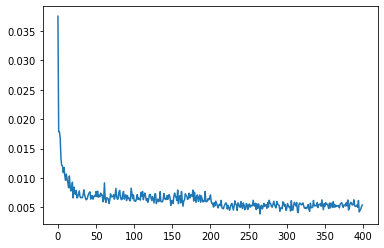

epoch:   0 loss: 0.00541942 lr: 0.01000000


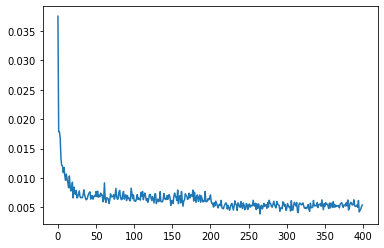

In [749]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(400):
    in_out_seq,in_out_seq_comb = create_sample(n_samples,length_sample,label_std,seq_std,label_offset)
    model.train(in_out_seq_comb,optimizer,loss_function,device,epochs=1,lr=1e-2,draw_fig=True)
    if i ==200: optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [700]:
print(model)

LSTM(
  (lstm): LSTM(2, 16, num_layers=2)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


In [744]:
loss, pred=model.test(in_out_seq_comb,loss_function,device)
loss_2=[]
for index, label_seq in enumerate(in_out_seq):
    #print(pred[index],label_seq[1])
    loss_2.append((pred[index]-label_seq[2])**2)
print(np.mean(loss))
np.mean(loss_2)

0.01324017482228266


0.013240174

In [417]:
n_samples = 500
length_sample = 8
labels = np.random.rand(n_samples, 1)
seqs = (np.random.rand(n_samples, length_sample)-.5)/2+labels
in_out_seq = [(torch.FloatTensor((seqs[index]).tolist()).to(device),
               torch.FloatTensor(label.tolist()).to(device))
              for index, label in enumerate(labels)]